# Deep Q-learning Tutorial

source: https://github.com/yuumii-san/RL_tutorial_notebook/tree/main

In this series of notebooks, I have introduced various policy iteration algorithms to solve Markov Decision Processes (MDPs). While these methods, which utilize tabular estimates of state/action values, work well in simpler settings, they face challenges in complex environments due to the great number of states and actions, making it impractical to learn with tabular estimates.

One solution to this problem is to employ a sophisticated function to efficiently estimate values. In this notebook, I will introduce one such approach known as Deep Q-learning (DQN). DQN utilizes a neural network to efficiently estimate state values. To address challenges when applying a neural network to estimate the value function, DQN incorporates techniques such as experience replay and a target Q-network.

We will learn these crucial conceptual elements with the implementation. So, let's get started

___

In [1]:
# Import packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable # Variable is depreciated in newer versions of PyTorch
from typing import List, Tuple
import torchinfo

import collections
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt
import random
import gymnasium as gym

from IPython.display import clear_output
from IPython import display

%matplotlib inline


In [2]:
x = 3
print(x)
clear_output()

In [3]:
# set random seeds
torch.manual_seed(0)
np.random.seed(0)

### Prepare environment

In this notebook, we utilize the CartPole-v0 environment in Gymnasium.

[Learn more about the CartPole-v0 environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

The goal of this environment is to balance a pole by applying forces in the left and right directions on the cart. It has a discrete action space:
- 0: Push cart to the left
- 1: Push cart to the right

Upon taking an action, either left or right, an agent observes a 4-dimensional state consisting of:
- Cart Position
- Cart Velocity
- Pole Angle
- Pole Angular Velocity

A reward of +1 is granted to the agent at each step while the pole is kept upright. The maximum reward an agent can earn in a single episode is 200.

The episode ends under the following conditions:
- Termination: Pole Angle is greater than ±12°
- Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- Truncation: Episode length exceeds 200 steps

In the code below, I provide an example of the agent randomly exploring this environment over 100 time steps.


In [4]:
# Create CartPole environment
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, _ = env.reset()

# # Run the environment for 100 steps
# for i in range(100):
#     print(f"Step {i + 1}")
#     # Display the current state of the environment
#     plt.imshow(env.render())
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
    
#     # Choose a random action from the action space
#     action = env.action_space.sample()
    
#     # Take the chosen action and observe the next state, reward, and termination status
#     state, reward, terminated, truncated, info = env.step(action)
    
#     # If the episode is terminated or truncated, reset the environment
#     if terminated or truncated:
#         state, info = env.reset()

# # Close the environment after exploration
# env.close()

In [5]:
print(f"{env.action_space = }")
print(f"{env.observation_space = }")

env.action_space = Discrete(2)
env.observation_space = Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


### Define Q-Network

Let's begin by preparing a model to estimate a value function. Here, we assume that the environment dynamics is unknow and the agent needs to learn the optimal policy by interacting with the environment. State space of CartPole-v0 is continuous, and the number of possible states is infinitely large. Therefore, applying a tabular estimate strategy, as done in Monte Carlo Methods or TD-learning, is not feasible. This is why we use a model to estimate the value based on the observed state.

For Deep Q-Network (DQN), we employ a deep learning model as a value function estimator. The estimated value function is referred to as the Q-value, and the neural network used for this purpose is known as the Q-network. This network takes a state ($\mathbb{R}^{Nx4}$) as an input and outputs Q values of the actions available to the agent ($\mathbb{R}^{Nx2}$). To keep it simple, we will utilize a fully connected neural network with ReLU activation. We use the Adam optimizer for training.


In [6]:
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(FullyConnectedModel, self).__init__()

        # Define layers with ReLU activation
        self.linear1 = nn.Linear(input_size, 16)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(16, 16)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 16)
        self.activation3 = nn.ReLU()

        # Output layer without activation function
        self.output_layer = nn.Linear(16, output_size)

        # Initialization using Xavier uniform (a popular technique for initializing weights in NNs)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_layer(x)
        return x
    
class QNetwork:
    def __init__(self, env, lr, input_size=4, logdir=None):
        # Define Q-network with specified architecture
        self.input_size = input_size
        self.net = FullyConnectedModel(4, 2)
        self.env = env
        self.lr = lr 
        self.logdir = logdir
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)

    def load_model(self, model_file):
        # Load pre-trained model from a file
        return self.net.load_state_dict(torch.load(model_file))

    def load_model_weights(self, weight_file):
        # Load pre-trained model weights from a file
        return self.net.load_state_dict(torch.load(weight_file))
    
    def print_state_dict_and_info(self):
        summary = torchinfo.summary(self.net, input_size=(1, self.input_size),
                          col_width=16, col_names=["output_size","kernel_size", "num_params"],  verbose=2)
        
        print("\nModel's state_dict:")
        for param_tensor in self.net.state_dict():
            print(param_tensor, "\t", self.net.state_dict()[param_tensor].size())

        print("\nOptimizer's state_dict:")
        for var_name in self.optimizer.state_dict():
            print(var_name, "\t", self.optimizer.state_dict()[var_name])


Note: The Xavier initialization (or Glorot initialization) is a popular technique for initializing weights in a neural network. For more information, you can check [this article](https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/).

### Define Replay Memory

Next, we introduce one of the key components of DQN, Experience Replay.

While deep learning models or other complex ML models for estimating a value function may seem appealing, they did not enjoy success in RL for a long time until Experience Replay was introduced. This is due to a correlation within the training dataset. In supervised learning, a crucial assumption is that all training data is independent and identically distributed (i.i.d). However, consecutive samples collected during the agent's interactions with the environment in RL are highly correlated, breaking this assumption and causing issues in fitting a machine learning model.

Experience Replay mitigates this temporal correlation by randomly sampling experiences from a replay memory. This approach helps decorrelate training samples, promoting better convergence. By storing and reusing past experiences, Experience Replay enables the agent to learn from a diverse set of transitions, making more efficient use of the collected data. This diversity aids in better exploration and can lead to more stable and faster convergence of the Q-network.

Specifically, we first define a replay memory with a specified memory size. On each iteration, we store a new observation in this replay memory and randomly sample data from this memory to train a model. This random sampling from a replay memory breaks the correlational structure in the training data.

Because of Replay Memory, DQN is classified as an off-policy method. On-Policy methods use the same policy for both collecting samples and updating the value function. 

In contrast, Off-Policy methods use two distinct policies for collecting samples and updating a value function, respectively. For DQN, experience samples are collected with an epsilon-greedy policy by using the Q-network estimate at the time. The accumulated experience in the memory buffer is then used to update the Q-network, consequently updating the policy by taking greedy action based on Q-network estimate. The data accumulated in the memory buffer does not follow the same policy as the current policy because we keep updating the Q-network. Thus, the data used to update our target policy is collected with different policies (i.e., Off-policy).

Let's set up the replay memory.

In [7]:
class ReplayMemory:
    def __init__(self, env, memory_size=int(5e4), burn_in=int(1e4)):
        # Initializes the replay memory, which stores transitions recorded from the agent taking actions in the environment.
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.memory = collections.deque([], maxlen=memory_size)
        self.env = env

    def sample_batch(self, batch_size=32):
        # Returns a batch of randomly sampled transitions to be used for training the model.
        return random.sample(self.memory, batch_size)

    def append(self, transition):
        # Appends a transition to the replay memory.
        self.memory.append(transition)


### Q-Value Function Update

As we discussed in the above section, to address the correlation problem in training data, we leverage a replay buffer. Samples extracted from the memory buffer are used to train our model. Let's learn the detailed process of updating a model.

Firstly, we utilize the Temporal Difference (TD) error to update the value of a state and action pair, following the principles of Q-learning, which is why this approach is termed Deep "Q-learning". Q-learning is an Off-policy TD learning algorithm.

The TD error is given by the formula:

$$ (R_{t+1} + \gamma \max_a Q(S_{t+1}, a)) - Q(S_t, A_t) $$

A crucial difference between an original Q-learning and DQN is that the current estimate of the Q-value $Q(S_t, A_t)$ and $Q(S_{t+1}, a)$ is obtained from a deep learning model. The model updates the prediction to minimize this TD error, meaning it uses the mean squared error between the estimated Q-value and the sum of the immediate reward and the value of the best next state-aciton pair.

However, there is a challenge. While our aim is to update the Q-value estimate by minimizing the TD error, the computation of the next state value $Q(S_{t+1}, a)$ within TD error equation also relies on the network, which we update at each iteration. As our value estimate for the next state fluctuates every iteration due to the network update, the error fluctuates too, leading to instability in the Q-network fitting.

To overcome this issue, DQN introduces another neural network called the target network. This network is updated more slowly compared to the policy Q-network, which we use to define the optimal policy based on the value estimation. Unlike the policy network, the target network is not updated every iteration. Instead, it is updated once in a while to stabilize the learning process.


### Define DQN Agent

Now that we have covered all the essential components (Deep Learning Model, Replay Memory, and Target Network), we can proceed with the implementation to train a DQN agent. The training of DQN in the below implementation roughly follows these steps:

1. Initialize Q-network and Target Network.
2. Initialize Replay Memory using burn-in with a random action policy.
3. Initialize the environment.
4. For each episode from 1 to M:
    1. Choose an action based on the current Q-value estimate using an epsilon-greedy policy.
    2. Take a step and observe the next state and reward.
    3. Store the new experience into the replay memory.
    4. Sample a minibatch with size N from the replay memory.
    5. Train the network with the batched dataset.
    6. Go back to step 1.
5. Every 10 episodes, perform 20 test episodes to evaluate the performance of the current agent.

Let's explore the implementation.


In [8]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN_Agent:

    def __init__(self, environment_name, lr=5e-4, render=False):
        # Initialize the DQN Agent.
        self.env = gym.make(environment_name)
        self.lr = lr # alpha
        self.policy_net = QNetwork(self.env, self.lr)
        self.target_net = QNetwork(self.env, self.lr)
        self.target_net.net.load_state_dict(self.policy_net.net.state_dict())  # Copy the weight of the policy network
        self.rm = ReplayMemory(self.env)
        self.burn_in_memory()
        # self.batch_size = 32
        self.batch_size = 256
        self.gamma = 0.99
        self.c = 0

    def burn_in_memory(self):
        # Initialize replay memory with a burn-in number of episodes/transitions.
        cnt = 0
        terminated, truncated  = False, False
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Iterate until we store "burn_in" buffer
        while cnt < self.rm.burn_in:
            # Reset environment if terminated or truncated
            if terminated or truncated:
                state, _ = self.env.reset()
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            
            # Randomly select an action (left or right) and take a step
            action = torch.tensor(random.sample([0, 1], 1)[0]).reshape(1, 1)
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
                
            # Store new experience into memory
            transition = Transition(state, action, next_state, reward)
            self.rm.memory.append(transition)
            state = next_state
            cnt += 1

    def epsilon_greedy_policy(self, q_values, epsilon=0.05):
        # Implement an epsilon-greedy policy. 
        p = random.random()
        if p > epsilon:
            with torch.no_grad():
                return self.greedy_policy(q_values)
        else:
            return torch.tensor([[self.env.action_space.sample()]], dtype=torch.long)

    def greedy_policy(self, q_values):
        # Implement a greedy policy for test time.
        return torch.argmax(q_values)
        
    def train(self):
        # Train the Q-network using Deep Q-learning.
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        terminated,truncated = False, False

        # Loop until reaching the termination state
        while not (terminated or truncated):
            with torch.no_grad():
                """
                example: tensor([[ 0.0149, -0.0221]])
                """
                q_values = self.policy_net.net(state)

            # Decide the next action with epsilon greedy strategy
            action = self.epsilon_greedy_policy(q_values).reshape(1, 1)
            
            # Take action and observe reward and next state
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Store the new experience
            transition = Transition(state, action, next_state, reward)
            self.rm.memory.append(transition)

            # Move to the next state
            state = next_state

            # Sample minibatch with size N from memory
            transitions = self.rm.sample_batch(self.batch_size)
            batch = Transition(*zip(*transitions))
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Get current and next state values
            """
            example usage of gather
            tensor = torch.tensor([[10, 20, 30], 
                       [40, 50, 60]])

            # Indices to gather
            indices = torch.tensor([[0], [2]])

            # Gather values
            result = tensor.gather(1, indices)
            >>tensor([[10],
                    [60]])
            """
            state_action_values = self.policy_net.net(state_batch).gather(1, action_batch) # extract values corresponding to the actions Q(S_t, A_t)
            next_state_values = torch.zeros(self.batch_size)
            
            with torch.no_grad():
                # no next_state_value update if an episode is terminated (next_satate = None)
                # only update the non-termination state values (Ref: https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/)
                next_state_values[non_final_mask] = self.target_net.net(non_final_next_states).max(1)[0] # extract max value
                
            # Update the model
            expected_state_action_values = reward_batch + (next_state_values * self.gamma)
            
            criterion = torch.nn.MSELoss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            
            self.policy_net.optimizer.zero_grad()
            loss.backward()
            self.policy_net.optimizer.step()

            # Update the target Q-network in each 50 steps
            self.c += 1
            if self.c % 50 == 0:
                self.target_net.net.load_state_dict(self.policy_net.net.state_dict())

    def test(self, model_file=None):
        # Evaluates the performance of the agent over 20 episodes.

        max_t = 1000
        state, _ = self.env.reset()
        rewards = []

        for t in range(max_t):
            state = torch.from_numpy(state).float().unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net.net(state)
            action = self.greedy_policy(q_values)
            state, reward, terminated, truncated, _ = self.env.step(action.item())
            rewards.append(reward)
            if terminated or truncated:
                break

        return np.sum(rewards)


### Train and Test DQN Agent

Let's train a DQN agent to evaluate its performance on the CartPole-v0 environment. In this environment, the maximum achievable reward for an agent in each episode is 200. We will train the model over 200 episodes, evaluating its performance every 10 episodes with an additional 20 test episodes. This training process will be repeated five times, allowing us to assess the average performance of the agent across episodes.

Please note that this section may take a few minutes to complete.


c:\Users\felikong\AppData\Local\miniconda3\envs\py310_2env\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0
The test reward for episode 0 is 12.75 with a standard deviation of 1.9716744153130354.
Episode: 10
The test reward for episode 10 is 9.6 with a standard deviation of 0.58309518948453.
Episode: 20
The test reward for episode 20 is 9.1 with a standard deviation of 0.7000000000000001.
Episode: 30
The test reward for episode 30 is 9.75 with a standard deviation of 0.698212002188447.
Episode: 40
The test reward for episode 40 is 16.35 with a standard deviation of 2.4753787588973126.
Episode: 50
The test reward for episode 50 is 9.45 with a standard deviation of 0.6689544080129824.
Episode: 60
The test reward for episode 60 is 9.25 with a standard deviation of 0.6224949798994366.
Episode: 70
The test reward for episode 70 is 36.8 with a standard deviation of 11.183022847155414.
Episode: 80
The test reward for episode 80 is 78.65 with a standard deviation of 28.922785135598545.
Episode: 90
The test reward for episode 90 is 199.0 with a standard deviation of 2.701851217221259.
Epis

 20%|██        | 1/5 [02:11<08:46, 131.53s/it]c:\Users\felikong\AppData\Local\miniconda3\envs\py310_2env\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Episode: 0
The test reward for episode 0 is 9.4 with a standard deviation of 0.7348469228349535.
Episode: 10
The test reward for episode 10 is 9.55 with a standard deviation of 0.5894913061275798.
Episode: 20
The test reward for episode 20 is 9.15 with a standard deviation of 0.7262919523166975.
Episode: 30
The test reward for episode 30 is 9.3 with a standard deviation of 0.7810249675906653.
Episode: 40
The test reward for episode 40 is 9.5 with a standard deviation of 0.5.
Episode: 50
The test reward for episode 50 is 9.5 with a standard deviation of 0.5916079783099616.
Episode: 60
The test reward for episode 60 is 9.35 with a standard deviation of 0.7262919523166976.
Episode: 70
The test reward for episode 70 is 114.7 with a standard deviation of 26.745279957405568.
Episode: 80
The test reward for episode 80 is 200.0 with a standard deviation of 0.0.
Episode: 90
The test reward for episode 90 is 200.0 with a standard deviation of 0.0.
Episode: 100
The test reward for episode 100 is 

 40%|████      | 2/5 [04:09<06:09, 123.30s/it]

Episode: 0
The test reward for episode 0 is 9.7 with a standard deviation of 0.9539392014169455.
Episode: 10
The test reward for episode 10 is 9.1 with a standard deviation of 0.7000000000000001.
Episode: 20
The test reward for episode 20 is 9.5 with a standard deviation of 1.02469507659596.
Episode: 30
The test reward for episode 30 is 9.3 with a standard deviation of 0.714142842854285.
Episode: 40
The test reward for episode 40 is 12.9 with a standard deviation of 4.036087214122113.
Episode: 50
The test reward for episode 50 is 26.9 with a standard deviation of 4.515528761950255.
Episode: 60
The test reward for episode 60 is 98.25 with a standard deviation of 12.632794623518583.
Episode: 70
The test reward for episode 70 is 199.2 with a standard deviation of 2.4207436873820405.
Episode: 80
The test reward for episode 80 is 197.5 with a standard deviation of 4.9749371855331.
Episode: 90
The test reward for episode 90 is 199.1 with a standard deviation of 2.981610303175114.
Episode: 10

 60%|██████    | 3/5 [06:13<04:08, 124.04s/it]

Episode: 0
The test reward for episode 0 is 9.1 with a standard deviation of 0.8888194417315589.
Episode: 10
The test reward for episode 10 is 11.1 with a standard deviation of 0.99498743710662.
Episode: 20
The test reward for episode 20 is 9.45 with a standard deviation of 0.6689544080129824.
Episode: 30
The test reward for episode 30 is 9.5 with a standard deviation of 0.6708203932499369.
Episode: 40
The test reward for episode 40 is 9.45 with a standard deviation of 0.739932429347437.
Episode: 50
The test reward for episode 50 is 23.15 with a standard deviation of 6.381810088054955.
Episode: 60
The test reward for episode 60 is 116.1 with a standard deviation of 33.64060047026509.
Episode: 70
The test reward for episode 70 is 187.9 with a standard deviation of 17.256592942988487.
Episode: 80
The test reward for episode 80 is 191.4 with a standard deviation of 16.53602128687551.
Episode: 90
The test reward for episode 90 is 197.1 with a standard deviation of 7.7517739905133975.
Episo

 80%|████████  | 4/5 [08:46<02:15, 135.16s/it]

Episode: 0
The test reward for episode 0 is 9.4 with a standard deviation of 0.8602325267042626.
Episode: 10
The test reward for episode 10 is 9.05 with a standard deviation of 0.7399324293474371.
Episode: 20
The test reward for episode 20 is 9.55 with a standard deviation of 0.739932429347437.
Episode: 30
The test reward for episode 30 is 8.85 with a standard deviation of 0.6538348415311012.
Episode: 40
The test reward for episode 40 is 9.5 with a standard deviation of 0.8660254037844386.
Episode: 50
The test reward for episode 50 is 26.05 with a standard deviation of 6.264782518172518.
Episode: 60
The test reward for episode 60 is 128.35 with a standard deviation of 47.41336836800355.
Episode: 70
The test reward for episode 70 is 179.25 with a standard deviation of 20.777090749188154.
Episode: 80
The test reward for episode 80 is 162.4 with a standard deviation of 15.311433636338565.
Episode: 90
The test reward for episode 90 is 164.55 with a standard deviation of 23.32482583000353.


100%|██████████| 5/5 [11:10<00:00, 134.18s/it]


Text(0, 0.5, 'Avg. Return')

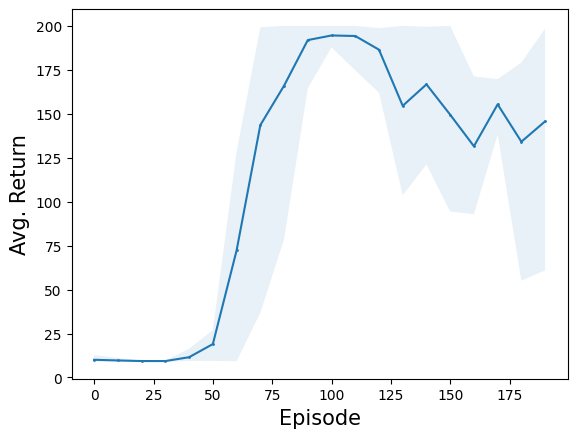

In [9]:
# Set environment and training parameters
env_name = 'CartPole-v0'
num_episodes_train = 200
num_episodes_test = 20
learning_rate = 5e-4

# Create the environment
env = gym.make(env_name)
action_space_size = env.action_space.n
state_space_size = 4

# Plot average performance of 5 trials
num_seeds = 5
l = num_episodes_train // 10
res = np.zeros((num_seeds, l))
gamma = 0.99

# Loop over multiple seeds
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Create an instance of the DQN_Agent class
    agent = DQN_Agent(env_name, lr=learning_rate)

    # Training loop
    for m in range(num_episodes_train):
        agent.train()

        # Evaluate the agent every 10 episodes during training
        if m % 10 == 0:
            print("Episode: {}".format(m))

            # Evaluate the agent's performance over 20 test episodes
            G = np.zeros(num_episodes_test)
            for k in range(num_episodes_test):
                g = agent.test()
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print(f"The test reward for episode {m} is {reward_mean} with a standard deviation of {reward_sd}.")
            reward_means.append(reward_mean)

    res[i] = np.array(reward_means)

# Plotting the average performance
ks = np.arange(l) * 10
avs = np.mean(res, axis=0)
maxs = np.max(res, axis=0)
mins = np.min(res, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Avg. Return', fontsize=15)


The plot above illustrates the average return, representing the total reward received by the agent in an episode, across 5 different runs. It is evident that the agent progressively learns a more effective strategy to achieve higher returns with an increasing number of episodes.

Now, let's observe the behavior of the trained agent in the environment.


In [11]:
# Create CartPole environment
env = gym.make('CartPole-v0', render_mode='human')
state, _ = env.reset()

# Run the environment for 100 steps
for i in range(200):
    # Display the current state of the environment
    env.render()
    # display.display(plt.gcf())
    # display.clear_output(wait=True)
    
    # Choose an action based on the learned Q-network
    state = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        q_values = agent.policy_net.net(state)
    action = agent.greedy_policy(q_values).detach().numpy()
    
    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, _ = env.step(action)
    
    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()

# Close the environment after exploration
env.close()

In [ ]:
# Create CartPole environment
env = gym.make('CartPole-v0', render_mode='rgb_array')
state, _ = env.reset()

# Run the environment for 100 steps
for i in range(100):
    # Display the current state of the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # Choose an action based on the learned Q-network
    state = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        q_values = agent.policy_net.net(state)
    action = agent.greedy_policy(q_values).detach().numpy()
    
    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, _ = env.step(action)
    
    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()

# Close the environment after exploration
env.close()


It properly choose the right or left action to maintain the pole position upright!

### Ref
- Mnih, Volodymyr, et al. "Human-level control through deep reinforcement learning." nature 518.7540 (2015): 529-533.
